# Project1 Classification Analysis on Textual Data

### Load Files

In [1]:
from sklearn.datasets import fetch_20newsgroups
categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware','comp.sys.mac.hardware','rec.autos','rec.motorcycles','rec.sport.baseball','rec.sport.hockey']
train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)
test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

### Problem A

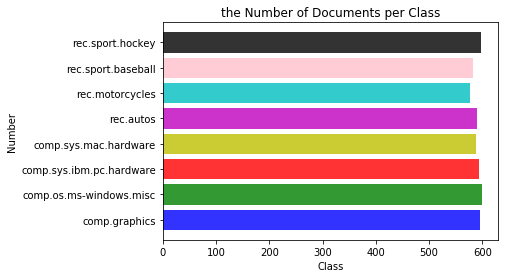

In [2]:
import matplotlib.pyplot as plt

value = {}
for i in train.target:
    if i not in value:
        value[i] = 0
    else:
        value[i] += 1
fig = plt.figure()
ax = fig.add_subplot(111)
colors = ['b','g','r','y','m','c','pink','k']
plt.barh(train.target_names, list(value.values()),alpha=0.8, color=colors)
plt.xlabel('Class')
plt.ylabel('Number')
plt.title('the Number of Documents per Class')
plt.legend()
plt.show()

### Problem B

First tokenize each document into words.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(min_df=1)
train_counts = count_vectorizer.fit_transform(train.data)
train_counts.shape

(4732, 79218)

Then, excluding the stop words, punctuations, and using stemmed version of words, create a TFxIDF vector representations.

In [4]:
from sklearn.feature_extraction import text
from nltk.stem.snowball import SnowballStemmer
import string,re

def stemming_tokenizer(text):
    stemmer = SnowballStemmer("english")
    text = "".join([a for a in text if a not in string.punctuation]) # remove all punctuation
    text = re.sub('[,.-:/()?{}*$#&]',' ', text) # remove all symbols
    text = "".join(b for b in text if ord(b) < 128) # remove all non-ascii characters
    words = text.split()
    stemmed = [stemmer.stem(item) for item in words]
    return stemmed

stop_words = text.ENGLISH_STOP_WORDS

count_vect_final = CountVectorizer(analyzer='word' , tokenizer=stemming_tokenizer, stop_words=stop_words, min_df=4, max_df =0.99)
train_counts_final = count_vect_final.fit_transform(train.data)

print ("Number of terms Extracted : " + str(train_counts_final.shape[1]))

Number of terms Extracted : 10741


TFxIDF

In [5]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
tfidf_train = tfidf_transformer.fit_transform(train_counts_final)
tfidf_train.shape

(4732, 10741)

### Problem C

Find the 10 most significant terms in each of the following classes with respect to TFxICF measure.

TF -- the term frequency in a class

In [6]:
all_categories = ['comp.graphics',
                'comp.os.ms-windows.misc',
                'comp.sys.ibm.pc.hardware',
                'comp.sys.mac.hardware',
                'comp.windows.x',
                'rec.autos',
                'rec.motorcycles',
                'rec.sport.baseball',
                'rec.sport.hockey',
                'alt.atheism',
                'sci.crypt',
                'sci.electronics',
                'sci.med',
                'sci.space',
                'soc.religion.christian',
                'misc.forsale',
                'talk.politics.guns',
                'talk.politics.mideast',
                'talk.politics.misc',
                'talk.religion.misc'
                ]

all_docs_per_category = []
for cate in all_categories:
    category_data = fetch_20newsgroups(subset='train',categories=[cate]).data
    temp = ""
    for doc in category_data:
        temp = temp + " "+ doc
    all_docs_per_category.append(temp)
    
vectorizer = CountVectorizer(analyzer='word',stop_words=stop_words, tokenizer=stemming_tokenizer)
vectorized_newsgroups_train = vectorizer.fit_transform(all_docs_per_category)
vectorized_newsgroups_train.shape

(20, 111882)

Calculate the TFxICF

In [7]:
tficf_train = tfidf_transformer.fit_transform(vectorized_newsgroups_train)

Find the 10 most significant terms

In [9]:
import numpy as np

tficf_train_copy = tficf_train.copy()
features = vectorizer.get_feature_names()
for i in [2, 3, 14, 15]:
    temp = []
    for j in range(10):
        temp.append(features[np.argmax(tficf_train_copy[i])])
        tficf_train_copy[i, np.argmax(tficf_train_copy[i])] = 0
    print(all_categories[i],temp)

comp.sys.ibm.pc.hardware ['scsi', 'drive', 'ide', 'use', 'line', 'subject', 'organ', 'card', 'control', 'mb']
comp.sys.mac.hardware ['line', 'mac', 'subject', 'organ', 'use', 'quadra', 'simm', 'appl', 'scsi', 'problem']
soc.religion.christian ['god', 'christian', 'jesus', 'church', 'subject', 'peopl', 'line', 'say', 'christ', 'believ']
misc.forsale ['line', 'subject', 'sale', 'organ', 'univers', 'new', 'use', 'offer', 'dos', 'nntppostinghost']


### Problem D

Apply LSI to TFxIDF matrix corresponding to the 8 classes, and pick k=50.

In [11]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler

SVD = TruncatedSVD(n_components=50, random_state=42)
transformed_tfidf = SVD.fit_transform(tfidf_train)
print("Dimensions of TF-IDF vector after LSI: "+ str(transformed_tfidf.shape))

Min_Max_Scaler = MinMaxScaler()# normalize
scaled_lsi = Min_Max_Scaler.fit_transform(transformed_tfidf)

Dimensions of TF-IDF vector after LSI: (4732, 50)


### Problem E

Use hard margin SVM classifer (SVC) to separate the documents into 'Computer Technology' vs 'Recreational Activity' groups.

test data preperation